In [2]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVR
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_
    
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

#### 3.3) Support Vector Machines
- - -

In [4]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


#### 3.1.1) Regression for Confirmed Cases
- - -

### Input normalized, increase as output

In [5]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [6]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [7]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [8]:
# create SVM instance, and check the hyper parameters
svm = SVR()
svm.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(svm, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.8min finished


Elapsed time: 6.368399651845296mins
Best score: -1669947.9503701779
Best parameters: {'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.1, 'C': 1}


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 155.0975705077451
MSE: 1664374.7031135997
RMSE: 1290.1064696813205
R^2: -0.010538630044780062


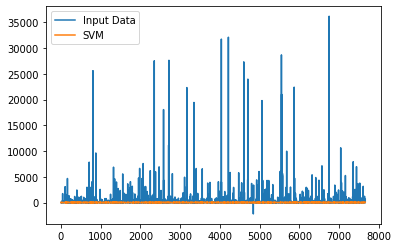

In [11]:
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM')

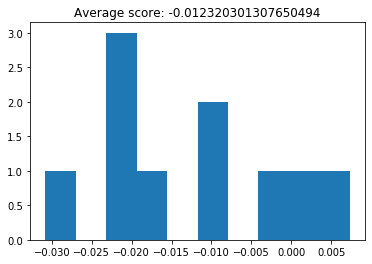

In [12]:
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

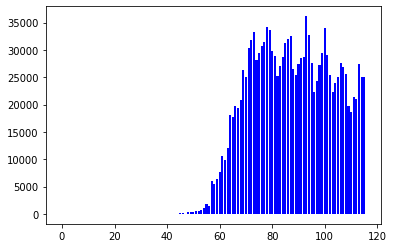

In [15]:
plot_pred_diff(
    df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 355266.36162415694
MSE: 358023134650.25244
RMSE: 598350.3444055602
R^2: -0.543087440024056


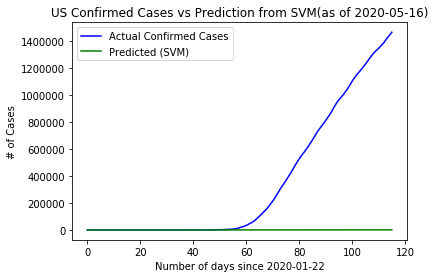

In [17]:
plot_predictions_for_country(
    df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 81934.22140457242
MSE: 15281547366.162544
RMSE: 123618.55591359473
R^2: -0.7647054037855372


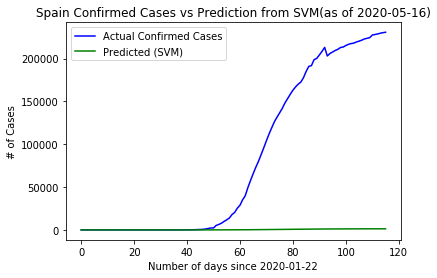

In [18]:
plot_predictions_for_country(
    df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 30063.97355381502
MSE: 3846116430.453935
RMSE: 62017.06563885408
R^2: -0.28819834492619134


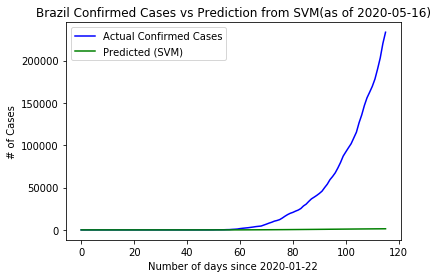

In [19]:
plot_predictions_for_country(
    df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 8353.224564852082
MSE: 175575910.14464465
RMSE: 13250.506033531121
R^2: -0.5294867384810118


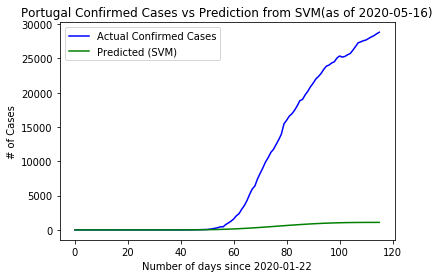

In [20]:
plot_predictions_for_country(
    df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 36075.03130237109
MSE: 6031251737.545815
RMSE: 77661.1340217603
R^2: -0.2558861643800754


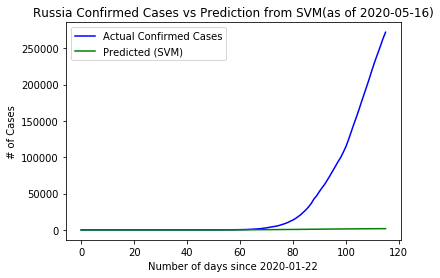

In [21]:
plot_predictions_for_country(
    df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 82224.58752493437
MSE: 14174118181.125725
RMSE: 119055.10564913091
R^2: -0.878927105072068


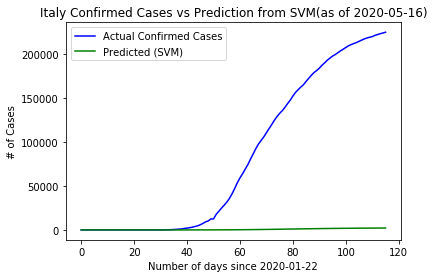

In [22]:
plot_predictions_for_country(
    df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM",
    True
)

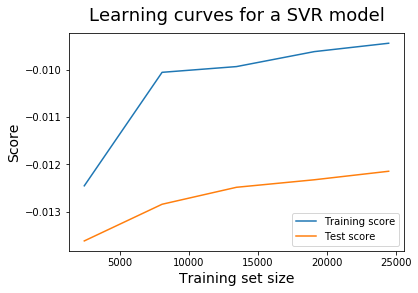

In [23]:
# learning curve
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

### Input non normalized, increase as output

In [24]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [25]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [26]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM Predictions')

In [ ]:
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

In [ ]:
plot_pred_diff(
    df, svm_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

In [ ]:
plot_predictions_for_country(
    df, "US", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Spain", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Brazil", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Portugal", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Russia", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
# learning curve
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

### Using increases in confirmed cases and normalized values, using increase as output

In [16]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [17]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [18]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [20]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.3min finished


Elapsed time: 4.886189385255178mins
Best score: -148504.37704141028
Best parameters: {'kernel': 'linear', 'gamma': 1, 'epsilon': 0.01, 'C': 1}


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 45.549489090155916
MSE: 198900.77267552956
RMSE: 445.9829286817261
R^2: 0.9083912124506439


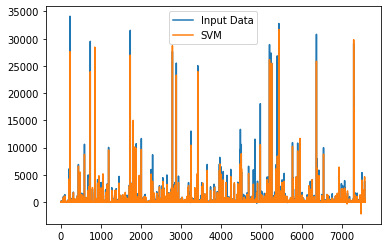

In [21]:
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM')

In [ ]:
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

In [ ]:
plot_pred_diff(
    new_df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

In [ ]:
plot_predictions_for_country(
    new_df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM",
    True
)

In [ ]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)

### Normalized inputs, cumulative as outputs

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

In [ ]:
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM Predictions')

In [ ]:
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

In [ ]:
plot_predictions_for_country(
    df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM"
)

In [ ]:
plot_predictions_for_country(
    df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM"
)

In [ ]:
plot_predictions_for_country(
    df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM"
)

In [ ]:
plot_predictions_for_country(
    df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM"
)

In [ ]:
plot_predictions_for_country(
    df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM"
)

In [ ]:
plot_predictions_for_country(
    df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM"
)

In [ ]:
# learning curve
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

### 3.4.2) Regression for Death Cases
### Using the best combination of parameters found for the confirmed deaths, for SVM the best option was COMPLETAR

In [ ]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

In [ ]:
outputs = new_df["Deaths_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

In [ ]:
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

In [ ]:
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

In [ ]:
plot_pred_diff(
    new_df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

In [ ]:
plot_predictions_for_country(
    new_df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "US Deaths Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Spain Deaths Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Brazil Deaths Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Portugal Deaths Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Russia Deaths Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Italy Deaths Cases vs Prediction from SVM",
    True
)

In [ ]:
# learning curve
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

### 3.4.3) Regression for Recovered Cases
### Using the best combination of parameters found for the confirmed deaths, for SVM the best option was COMPLETAR

In [ ]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

In [ ]:
outputs = new_df["Recovered_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

In [ ]:
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM Predictions')

In [ ]:
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

In [ ]:
plot_pred_diff(
    new_df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

In [ ]:
plot_predictions_for_country(
    new_df, "US", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "US Recovered Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Spain", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Spain Recovered Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Brazil", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Brazil Recovered Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Portugal", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Portugal Recovered Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Russia", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Russia Recovered Cases vs Prediction from SVM",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Italy Recovered Cases vs Prediction from SVM",
    True
)

In [ ]:
# learning curve
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)